✅ Best RandomForest Params: {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 200}
✅ Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
📌 Cross-Validated Training Accuracy: 0.8810

📌 Best Threshold for Voting Classifier: 0.6072 (Dynamically Selected)

🔍 Voting Classifier (Medically Adjusted) Performance:
✅ Accuracy: 0.9524
✅ Precision: 0.9130
✅ Recall: 1.0000
✅ F1-Score: 0.9545
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        42
           1       0.91      1.00      0.95        42

    accuracy                           0.95        84
   macro avg       0.96      0.95      0.95        84
weighted avg       0.96      0.95      0.95        84



<Figure size 600x600 with 0 Axes>

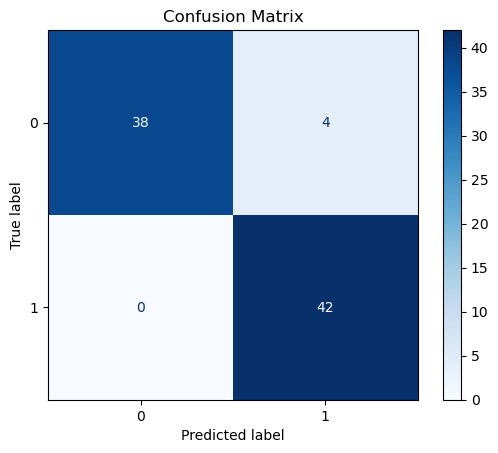

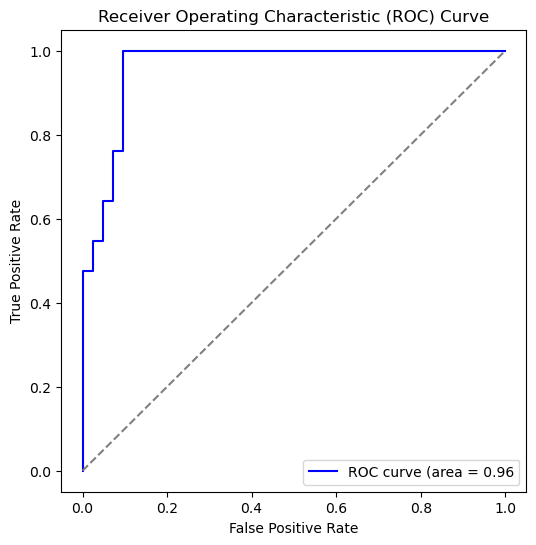

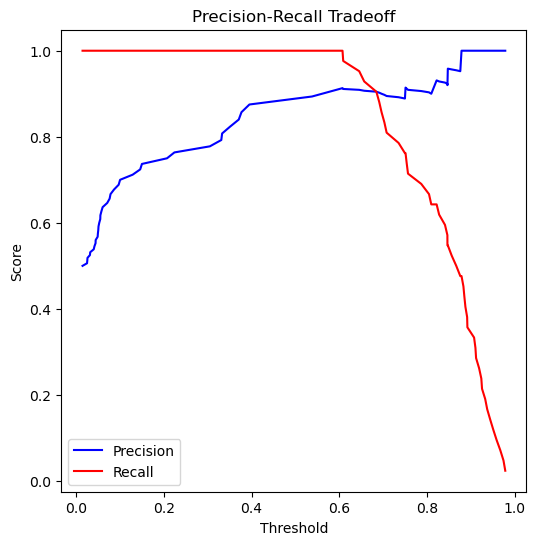

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve,
    confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)

# 📌 **1. Load dataset**
df = pd.read_csv("balanced_spine_data.csv")

# Define X (features) and y (target)
X = df.drop(columns=["class_label"])
y = df["class_label"]

# 📌 **2. Feature Scaling**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 📌 **3. Split dataset (80-20)**
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 📌 **4. Hyperparameter Tuning for Random Forest**
rf_params = {
    "n_estimators": [100, 200],  
    "max_depth": [8, 10],  
    "min_samples_split": [10, 15],  
    "min_samples_leaf": [7, 10]  
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                       rf_params, cv=7, scoring="f1", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("✅ Best RandomForest Params:", rf_grid.best_params_)

# 📌 **5. Hyperparameter Tuning for SVM**
svm_params = {"C": [10, 12], "kernel": ["rbf"], "gamma": ["scale"]}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=7, scoring="f1", n_jobs=-1)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
print("✅ Best SVM Params:", svm_grid.best_params_)

# 📌 **6. Voting Classifier (Random Forest + SVM)**
voting_clf = VotingClassifier(
    estimators=[("rf", best_rf), ("svm", best_svm)],
    voting="soft"
)
voting_clf.fit(X_train, y_train)

# 📌 **7. Cross-Validation for Reliable Training Accuracy**
cv_train_acc = cross_val_score(voting_clf, X_train, y_train, cv=7, scoring="accuracy").mean()
print(f"📌 Cross-Validated Training Accuracy: {cv_train_acc:.4f}")

# 📌 **8. Predictions**
y_probs = voting_clf.predict_proba(X_test)[:, 1]

# 📊 **9. Threshold Tuning for Best Precision-Recall Tradeoff**
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
print(f"\n📌 Best Threshold for Voting Classifier: {best_threshold:.4f} (Dynamically Selected)")

# 📌 **10. Medical Adjustment Logic**
def medical_adjustment(pred_proba, X_test, threshold=0.6136, margin=0.02):
    y_pred_adjusted = (pred_proba >= threshold).astype(int)
    for i in range(len(X_test)):
        ml_confidence = abs(pred_proba[i] - threshold)
        abnormal_score = 0
        if X_test.iloc[i]["degree_spondylolisthesis"] > 20:  
            abnormal_score += 2  
        if X_test.iloc[i]["pelvic_tilt"] > 25:  
            abnormal_score += 1  
        if X_test.iloc[i]["lumbar_lordosis_angle"] < 32 or X_test.iloc[i]["lumbar_lordosis_angle"] > 68:  
            abnormal_score += 1  
        if X_test.iloc[i]["pelvic_incidence"] < 38 or X_test.iloc[i]["pelvic_incidence"] > 68:  
            abnormal_score += 1  
        if abnormal_score >= 2 and ml_confidence < margin:  
            y_pred_adjusted[i] = 1  
    return y_pred_adjusted

# Apply Medical Adjustment
y_pred_adjusted = medical_adjustment(y_probs, pd.DataFrame(X_test, columns=X.columns), threshold=best_threshold)

# 📌 **11. Model Evaluation Function**
def evaluate_model(model_name, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n🔍 {model_name} Performance:")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall: {rec:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    return acc, prec, rec, f1

# 📌 **12. Evaluate Final Model**
final_results = evaluate_model("Voting Classifier (Medically Adjusted)", y_test, y_pred_adjusted)

# 📌 **13. Confusion Matrix**
plt.figure(figsize=(6,6))
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 📌 **14. ROC Curve**
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# 📌 **15. Precision-Recall Curve**
plt.figure(figsize=(6,6))
plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff")
plt.show()


In [23]:
import joblib

# Save the trained models
joblib.dump(best_rf, "random_forest_model.pkl")
joblib.dump(best_svm, "svm_model.pkl")
joblib.dump(voting_clf, "voting_classifier.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Models saved successfully!")


✅ Models saved successfully!
